In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mmichelli/cirrus-cumulus-stratus-nimbus-ccsn-database")

print("Path to dataset files:", path)
data_dir = pathlib.Path('/kaggle/input/cirrus-cumulus-stratus-nimbus-ccsn-database/CCSN_v2')


Path to dataset files: /kaggle/input/cirrus-cumulus-stratus-nimbus-ccsn-database


In [2]:
import numpy as np
import tensorflow as tf
import random
import os

# Set random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)


In [19]:
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
print("Class names in the dataset:")
for class_name in class_names:
    print(class_name)

Class names in the dataset:
Ac
As
Cb
Cc
Ci
Cs
Ct
Cu
Ns
Sc
St


In [4]:
import tensorflow as tf
import pathlib
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
import os

# Set the data directory
data_dir = pathlib.Path('/kaggle/input/cirrus-cumulus-stratus-nimbus-ccsn-database/CCSN_v2')

# Define the augmentation parameters (removed contrast_range)
datagen = ImageDataGenerator(
    rotation_range=20,          # Rotate up to 20 degrees
    horizontal_flip=True,       # Random horizontal flips
    zoom_range=0.2,            # Random zoom up to 20%
    brightness_range=[0.8, 1.2],# Adjust brightness between 80% and 120%
    fill_mode='nearest'         # Fill mode for new pixels
)

# Output directory for augmented images
output_dir = pathlib.Path('./augmented_images')
output_dir.mkdir(exist_ok=True)

# Function to apply contrast adjustment manually
def adjust_contrast(image):
    contrast_factor = np.random.uniform(0.8, 1.2)  # Random contrast between 80% and 120%
    return tf.image.adjust_contrast(image, contrast_factor)

# Number of augmentations per image
augmentations_per_image = 5

# Process each class folder
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
for class_name in class_names:
    class_dir = data_dir / class_name
    output_class_dir = output_dir / class_name
    output_class_dir.mkdir(exist_ok=True)
    
    # Process each image in the class folder
    for img_path in class_dir.glob('*'):
        # Load the image
        img = load_img(img_path)
        img_array = img_to_array(img)
        
        # Manually apply contrast adjustment to the original image
        img_array = adjust_contrast(img_array).numpy()
        img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for datagen
        
        # Generate augmented images
        i = 0
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=output_class_dir, 
                                save_prefix=f'aug_{img_path.stem}', save_format='jpg'):
            i += 1
            if i >= augmentations_per_image:
                break
        
        # Optionally save the original image too
        save_img(output_class_dir / f'original_{img_path.name}', img_array[0])

print(f"Augmented dataset created with {augmentations_per_image} versions per image at: {output_dir}")

Augmented dataset created with 5 versions per image at: augmented_images


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
from sklearn.model_selection import train_test_split
import os
import shutil

# Paths
data_dir = pathlib.Path('./augmented_images')
temp_dir = pathlib.Path('./temp_split')
train_dir = temp_dir / 'train'
val_dir = temp_dir / 'val'
test_dir = temp_dir / 'test'

# Create directories
for directory in [train_dir, val_dir, test_dir]:
    directory.mkdir(parents=True, exist_ok=True)

# Get all file paths and their class labels
all_files = []
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
for class_name in class_names:
    class_files = list((data_dir / class_name).glob('*'))
    all_files.extend([(f, class_name) for f in class_files])

# Split into train+val (90%) and test (10%)
train_val_files, test_files = train_test_split(all_files, test_size=0.1, stratify=[f[1] for f in all_files], random_state=42)

# Split train+val into train (70%) and val (20%) of total dataset
train_files, val_files = train_test_split(train_val_files, test_size=0.2222, stratify=[f[1] for f in train_val_files], random_state=42)  # 20/(70+20) ≈ 0.2222

# Copy files to respective directories
for files, target_dir in [(train_files, train_dir), (val_files, val_dir), (test_files, test_dir)]:
    for file_path, class_name in files:
        class_dir = target_dir / class_name
        class_dir.mkdir(exist_ok=True)
        shutil.copy(file_path, class_dir / file_path.name)

# Define preprocessing for Xception (rescale to [-1, 1])
datagen = ImageDataGenerator(
    rescale=1./127.5,  # Scale to [0, 2]
    preprocessing_function=lambda x: x - 1.0  # Shift to [-1, 1]
)

# Create generators
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)
val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)
test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # No shuffle for testing
)

# Print class names and counts
class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", val_generator.samples)
print("Number of testing samples:", test_generator.samples)

# Verify split percentages
total_samples = train_generator.samples + val_generator.samples + test_generator.samples
print(f"Training split: {train_generator.samples / total_samples * 100:.1f}%")
print(f"Validation split: {val_generator.samples / total_samples * 100:.1f}%")
print(f"Testing split: {test_generator.samples / total_samples * 100:.1f}%")

Found 10680 images belonging to 11 classes.
Found 3052 images belonging to 11 classes.
Found 1526 images belonging to 11 classes.
Class names: ['Ac', 'As', 'Cb', 'Cc', 'Ci', 'Cs', 'Ct', 'Cu', 'Ns', 'Sc', 'St']
Number of training samples: 10680
Number of validation samples: 3052
Number of testing samples: 1526
Training split: 70.0%
Validation split: 20.0%
Testing split: 10.0%


In [6]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
import gc

# Clear any existing session to free memory
tf.keras.backend.clear_session()

# Reduce batch size to 16
batch_size = 16

# Re-define generators with smaller batch size
datagen = ImageDataGenerator(
    rescale=1./127.5,
    preprocessing_function=lambda x: x - 1.0
)

train_generator = datagen.flow_from_directory(
    './temp_split/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    './temp_split/val',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
test_generator = datagen.flow_from_directory(
    './temp_split/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load pretrained Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the first third of layers
total_layers = len(base_model.layers)
freeze_layers = total_layers // 3
for layer in base_model.layers[:freeze_layers]:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(11, activation='softmax')
])

Found 10680 images belonging to 11 classes.
Found 3052 images belonging to 11 classes.
Found 1526 images belonging to 11 classes.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Found 10680 images belonging to 11 classes.
Found 3052 images belonging to 11 classes.
Found 1526 images belonging to 11 classes.
Starting initial training...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


668/668 ━━━━━━━━━━━━━━━━━━━━ 113s 126ms/step - accuracy: 0.4462 - loss: 1.6407 - val_accuracy: 0.7205 - val_loss: 0.8229
Epoch 2/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 69s 103ms/step - accuracy: 0.8489 - loss: 0.4886 - val_accuracy: 0.8486 - val_loss: 0.4653
Epoch 3/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 69s 102ms/step - accuracy: 0.9579 - loss: 0.1632 - val_accuracy: 0.8630 - val_loss: 0.4676
Epoch 4/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 69s 103ms/step - accuracy: 0.9631 - loss: 0.1196 - val_accuracy: 0.8689 - val_loss: 0.4723
Epoch 5/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 69s 103ms/step - accuracy: 0.9763 - loss: 0.0847 - val_accuracy: 0.8739 - val_loss: 0.4490
Epoch 6/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 69s 102ms/step - accuracy: 0.9785 - loss: 0.0735 - val_accuracy: 0.8732 - val_loss: 0.4995
Epoch 7/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 69s 102ms/step - accuracy: 0.9748 - loss: 0.0769 - val_accuracy: 0.8719 - val_loss: 0.5036
Epoch 8/50
668/668 ━━━━━━━━━━━━━━━━━━━━ 69s 103ms/step - accuracy: 0.9826 - loss: 0.0536 - va

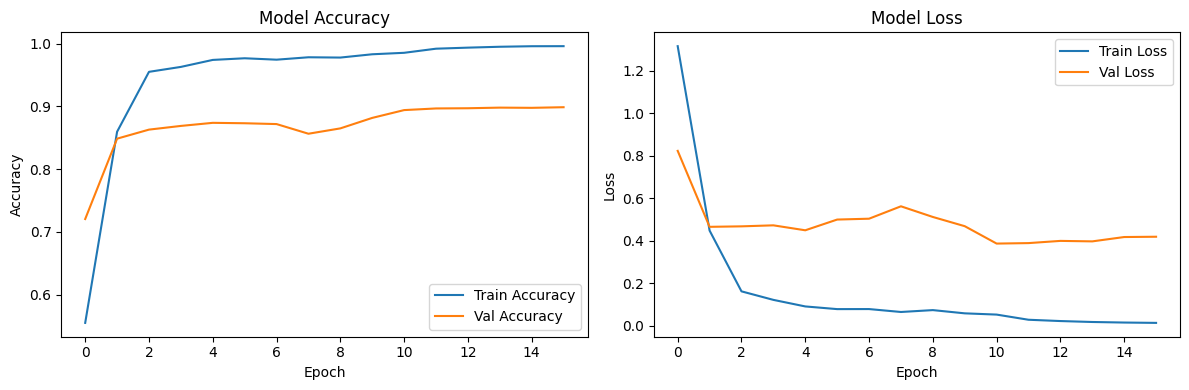

In [17]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np
import gc

# Clear any existing session to free memory
tf.keras.backend.clear_session()

# Reduce batch size to 16
batch_size = 16

# Re-define generators with smaller batch size
datagen = ImageDataGenerator(
    rescale=1./127.5,
    preprocessing_function=lambda x: x - 1.0
)

train_generator = datagen.flow_from_directory(
    './temp_split/train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    './temp_split/val',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_directory(
    './temp_split/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Load pretrained Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the first third of layers
total_layers = len(base_model.layers)
freeze_layers = total_layers // 3
for layer in base_model.layers[:freeze_layers]:
    layer.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(11, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Reduced for quicker testing
    restore_best_weights=True,
    verbose=1
)

# Train with frozen layers (fewer epochs for testing)
print("Starting initial training...")
history = model.fit(
    train_generator,
    epochs=50,  # Test with 10 epochs first
    validation_data=val_generator,
    callbacks=[early_stopping],
    verbose=1
)

# Clear memory before fine-tuning
gc.collect()
tf.keras.backend.clear_session()

# Fine-tuning: Unfreeze all layers
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
print("Starting fine-tuning...")
history_fine = model.fit(
    train_generator,
    epochs=25,  # Test with 25 epochs
    validation_data=val_generator,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate on test set
test_generator.reset()
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import numpy as np
import os

# Paths (using your existing augmented_images directory)
data_dir = pathlib.Path('./augmented_images')

# Define rain/no-rain mapping based on cloud types
rain_clouds = ['Ns', 'Cb']  # Clouds typically associated with rain
class_names = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])

# Function to assign rainfall labels based on class names
def get_rainfall_label(class_name):
    return 1 if class_name in rain_clouds else 0

# Create a dictionary to map class indices to rainfall labels
class_to_rainfall = {cls: get_rainfall_label(cls) for cls in class_names}
print("Rainfall mapping:", class_to_rainfall)

# Re-use your existing train/val/test split directories
train_dir = pathlib.Path('./temp_split/train')
val_dir = pathlib.Path('./temp_split/val')
test_dir = pathlib.Path('./temp_split/test')

# Update generators to include rainfall labels
def create_dual_output_generator(directory, batch_size=16):
    datagen = ImageDataGenerator(
        rescale=1./127.5,
        preprocessing_function=lambda x: x - 1.0
    )
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    
    # Custom generator to yield both cloud type and rainfall labels
    while True:
        images, cloud_labels = next(generator)
        rainfall_labels = np.array([class_to_rainfall[class_names[np.argmax(label)]] 
                                   for label in cloud_labels], dtype=np.float32)
        yield images, {'cloud_output': cloud_labels, 'rainfall_output': rainfall_labels}

# Create generators with dual outputs
train_generator = create_dual_output_generator(train_dir, batch_size=16)
val_generator = create_dual_output_generator(val_dir, batch_size=16)
test_generator = create_dual_output_generator(test_dir, batch_size=16)

# Test the generator
images, labels = next(train_generator)
print("Batch shape:", images.shape)
print("Cloud labels shape:", labels['cloud_output'].shape)
print("Rainfall labels shape:", labels['rainfall_output'].shape)

Rainfall mapping: {'Ac': 0, 'As': 0, 'Cb': 1, 'Cc': 0, 'Ci': 0, 'Cs': 0, 'Ct': 0, 'Cu': 0, 'Ns': 1, 'Sc': 0, 'St': 0}
Found 10680 images belonging to 11 classes.
Batch shape: (16, 224, 224, 3)
Cloud labels shape: (16, 11)
Rainfall labels shape: (16,)


Starting initial training...
Epoch 1/5
Found 10680 images belonging to 11 classes.
667/667 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - cloud_output_accuracy: 0.4077 - cloud_output_loss: 1.7288 - loss: 2.3752 - rainfall_output_accuracy: 0.7257 - rainfall_output_loss: 0.6463Found 3052 images belonging to 11 classes.

Epoch 1: val_loss improved from inf to 1.12472, saving model to best_model.keras
667/667 ━━━━━━━━━━━━━━━━━━━━ 104s 110ms/step - cloud_output_accuracy: 0.4079 - cloud_output_loss: 1.7283 - loss: 2.3745 - rainfall_output_accuracy: 0.7258 - rainfall_output_loss: 0.6461 - val_cloud_output_accuracy: 0.7122 - val_cloud_output_loss: 0.8490 - val_loss: 1.1247 - val_rainfall_output_accuracy: 0.8987 - val_rainfall_output_loss: 0.2757
Epoch 2/5
667/667 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - cloud_output_accuracy: 0.7878 - cloud_output_loss: 0.6386 - loss: 0.8218 - rainfall_output_accuracy: 0.9387 - rainfall_output_loss: 0.1837
Epoch 2: val_loss improved from 1.12472 to 0.71701, saving model to be

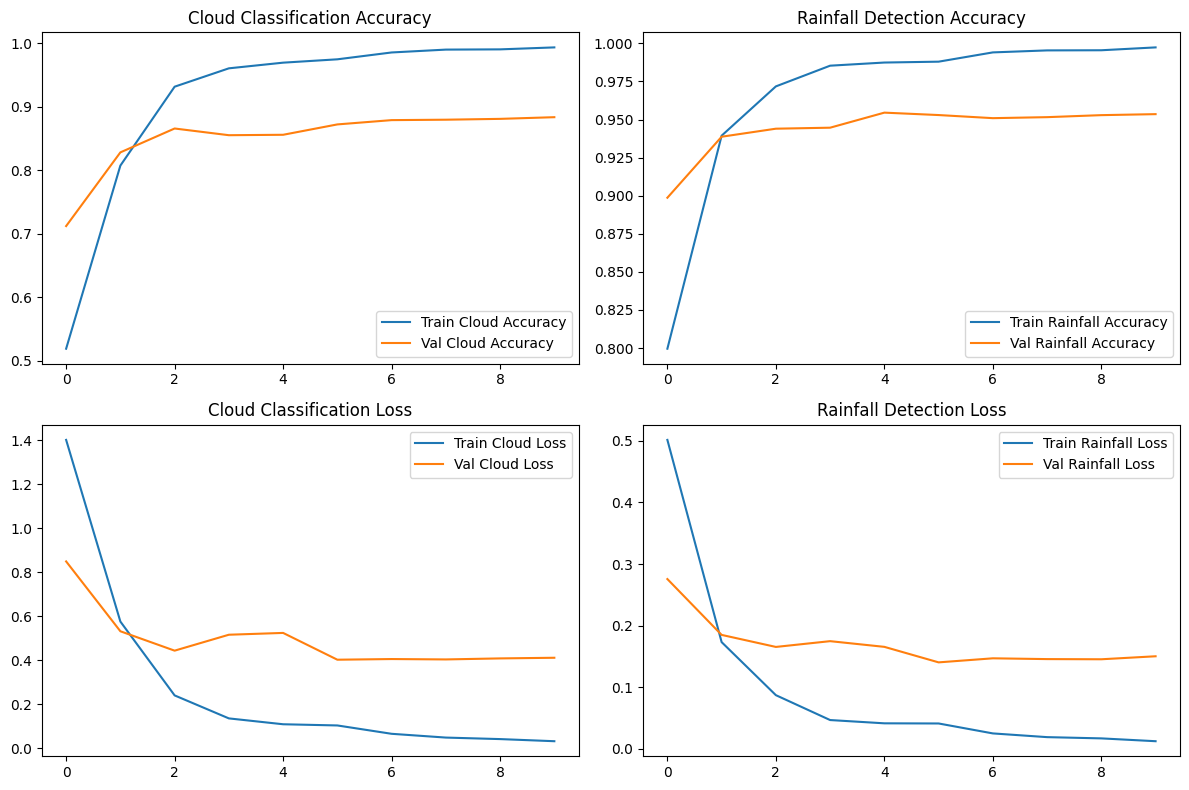

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pathlib

# Clear session
tf.keras.backend.clear_session()

# Define rainfall mapping (three classes, including Ct)
rainfall_mapping = {
    'Ci': 0, 'Cs': 0, 'Cc': 0, 'Ac': 0, 'Ct': 0,  # No Rain to Very Low Rain
    'As': 1, 'Sc': 1, 'St': 1, 'Ns': 1,           # Low to Medium Rain
    'Cb': 2, 'Cu': 2                              # Medium to High Rain
}

# Generator (adapted from your setup, updated for three-class rainfall)
def create_dual_output_generator(directory, batch_size=16):
    datagen = ImageDataGenerator(
        rescale=1./127.5,
        preprocessing_function=lambda x: x - 1.0
    )
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )
    class_names = sorted(generator.class_indices.keys())
    while True:
        images, cloud_labels = next(generator)
        rainfall_labels = np.array([rainfall_mapping[class_names[np.argmax(label)]] 
                                   for label in cloud_labels], dtype=np.int32)
        rainfall_labels_onehot = tf.keras.utils.to_categorical(rainfall_labels, num_classes=3)
        yield images, (cloud_labels, rainfall_labels_onehot)

# Define paths
train_dir = pathlib.Path('./temp_split/train')
val_dir = pathlib.Path('./temp_split/val')
test_dir = pathlib.Path('./temp_split/test')
class_names = sorted([item.name for item in train_dir.glob('*') if item.is_dir()])

# Dataset sizes (from your previous output)
train_samples = 10678
val_samples = 3051
test_samples = 1526
batch_size = 16

# Create datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: create_dual_output_generator(train_dir, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        (
            tf.TensorSpec(shape=(None, 11), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
        )
    )
).repeat()

val_dataset = tf.data.Dataset.from_generator(
    lambda: create_dual_output_generator(val_dir, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        (
            tf.TensorSpec(shape=(None, 11), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
        )
    )
).repeat()

test_dataset = tf.data.Dataset.from_generator(
    lambda: create_dual_output_generator(test_dir, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        (
            tf.TensorSpec(shape=(None, 11), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
        )
    )
)

# Load pretrained Xception model 
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:len(base_model.layers) // 3]:
    layer.trainable = False

# Define model (adapted from your setup)
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  # Your dropout layer
cloud_output = Dense(11, activation='softmax', name='cloud_output')(x)
rainfall_output = Dense(3, activation='softmax', name='rainfall_output')(x)  
model = Model(inputs=inputs, outputs=[cloud_output, rainfall_output])

# Compile (same as your setup, updated for three-class rainfall)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=['categorical_crossentropy', 'categorical_crossentropy'],  # Updated for three-class
    metrics=['accuracy', 'accuracy']
)

# Callbacks (same as your setup)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Train parameters
train_steps = train_samples // batch_size
val_steps = val_samples // batch_size
test_steps = test_samples // batch_size

# Train (simplified epochs for testing)
print("Starting initial training...")
history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    epochs=5,  # Reduced for testing
    validation_data=val_dataset,
    validation_steps=val_steps,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Fine-tune (same as your setup)
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=['categorical_crossentropy', 'categorical_crossentropy'],
    metrics=['accuracy', 'accuracy']
)

print("Starting fine-tuning...")
history_fine = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    epochs=5,  # Reduced for testing
    validation_data=val_dataset,
    validation_steps=val_steps,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# Evaluate (simplified evaluation)
test_results = model.evaluate(test_dataset, steps=test_steps, return_dict=True)
print("Test Results:")
print(f"Total Loss: {test_results['loss']:.4f}")
print(f"Cloud Loss: {test_results['cloud_output_loss']:.4f}")
print(f"Rainfall Loss: {test_results['rainfall_output_loss']:.4f}")
print(f"Cloud Accuracy: {test_results['cloud_output_accuracy']:.4f}")
print(f"Rainfall Accuracy: {test_results['rainfall_output_accuracy']:.4f}")

# Detailed evaluation (simplified)
test_dataset_for_eval = test_dataset.take(test_steps)
y_true_cloud = []
y_pred_cloud = []
y_true_rain = []
y_pred_rain = []

for images, (cloud_labels, rainfall_labels) in test_dataset_for_eval:
    predictions = model.predict(images)
    cloud_preds = np.argmax(predictions[0], axis=1)
    rain_preds = np.argmax(predictions[1], axis=1)
    y_true_cloud.extend(np.argmax(cloud_labels, axis=1))
    y_pred_cloud.extend(cloud_preds)
    y_true_rain.extend(np.argmax(rainfall_labels, axis=1))
    y_pred_rain.extend(rain_preds)

print("Cloud Classification Report:")
print(classification_report(y_true_cloud, y_pred_cloud, target_names=class_names))
print("Rainfall Detection Report:")
print(classification_report(y_true_rain, y_pred_rain, 
                           target_names=['No Rain to Very Low Rain', 'Low to Medium Rain', 'Medium to High Rain']))

# Plotting (same as your setup)
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(history.history['cloud_output_accuracy'] + history_fine.history['cloud_output_accuracy'], label='Train Cloud Accuracy')
plt.plot(history.history['val_cloud_output_accuracy'] + history_fine.history['val_cloud_output_accuracy'], label='Val Cloud Accuracy')
plt.title('Cloud Classification Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['rainfall_output_accuracy'] + history_fine.history['rainfall_output_accuracy'], label='Train Rainfall Accuracy')
plt.plot(history.history['val_rainfall_output_accuracy'] + history_fine.history['val_rainfall_output_accuracy'], label='Val Rainfall Accuracy')
plt.title('Rainfall Detection Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(history.history['cloud_output_loss'] + history_fine.history['cloud_output_loss'], label='Train Cloud Loss')
plt.plot(history.history['val_cloud_output_loss'] + history_fine.history['val_cloud_output_loss'], label='Val Cloud Loss')
plt.title('Cloud Classification Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history.history['rainfall_output_loss'] + history_fine.history['rainfall_output_loss'], label='Train Rainfall Loss')
plt.plot(history.history['val_rainfall_output_loss'] + history_fine.history['val_rainfall_output_loss'], label='Val Rainfall Loss')
plt.title('Rainfall Detection Loss')
plt.legend()

plt.tight_layout()
plt.show()

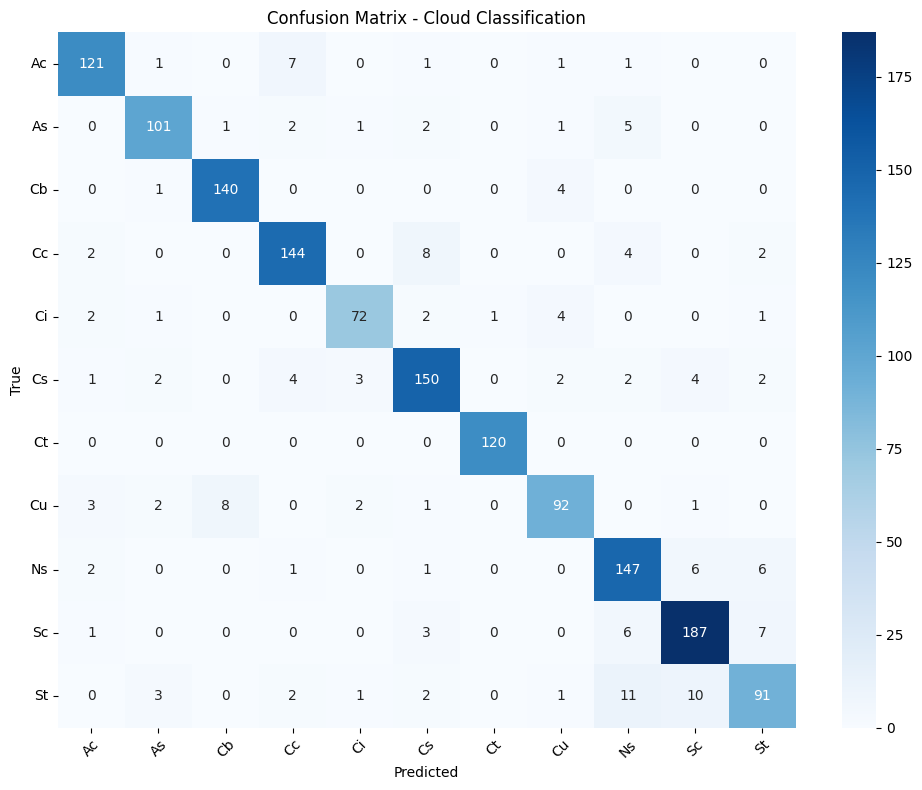

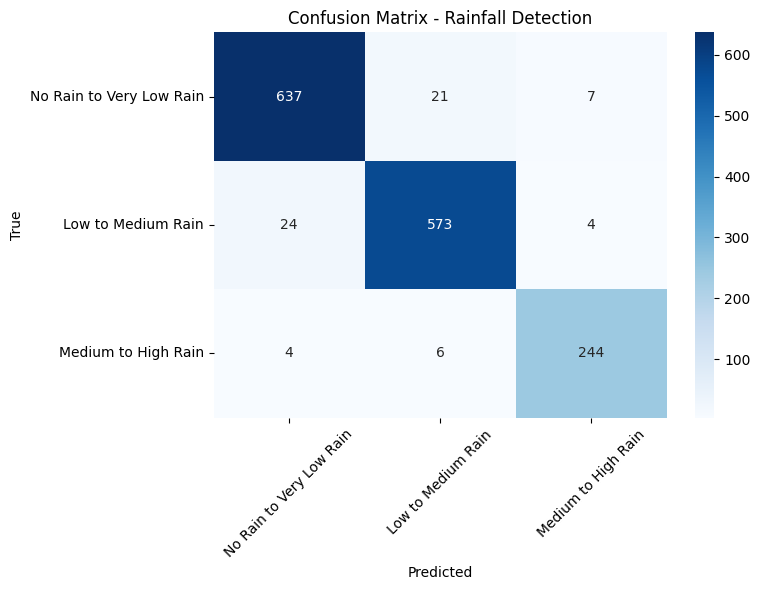

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrices
cm_cloud = confusion_matrix(y_true_cloud, y_pred_cloud)
cm_rain = confusion_matrix(y_true_rain, y_pred_rain)

# Plot confusion matrix for cloud classification
plt.figure(figsize=(10, 8))
sns.heatmap(cm_cloud, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Cloud Classification')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot confusion matrix for rainfall detection
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rain, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Rain to Very Low Rain', 'Low to Medium Rain', 'Medium to High Rain'],
            yticklabels=['No Rain to Very Low Rain', 'Low to Medium Rain', 'Medium to High Rain'])
plt.title('Confusion Matrix - Rainfall Detection')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [11]:
# Save the model
model.save('/kaggle/working/cloud_rainfall_model.h5')

# Save class names and rainfall mapping
import json
class_names = ['Ac', 'As', 'Cb', 'Cc', 'Ci', 'Cs', 'Ct', 'Cu', 'Ns', 'Sc', 'St']  # Ensure this matches your notebook
rainfall_mapping = {
    'Ci': 0, 'Cs': 0, 'Cc': 0, 'Ac': 0, 'Ct': 0,  # No Rain to Very Low Rain
    'As': 1, 'Sc': 1, 'St': 1, 'Ns': 1,          # Low to Medium Rain
    'Cb': 2, 'Cu': 2                             # Medium to High Rain
}
with open('/kaggle/working/class_names.json', 'w') as f:
    json.dump(class_names, f)
with open('/kaggle/working/rainfall_mapping.json', 'w') as f:
    json.dump(rainfall_mapping, f)

Found 1526 images belonging to 11 classes.
95/95 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - cloud_output_accuracy: 0.8640 - cloud_output_loss: 0.4505 - loss: 0.6483 - rainfall_output_accuracy: 0.9423 - rainfall_output_loss: 0.1978
Test Results:
Total Loss: 0.6085
Cloud Loss: 0.4345
Rainfall Loss: 0.1740
Cloud Accuracy: 0.8697
Rainfall Accuracy: 0.9454
Found 1526 images belonging to 11 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 

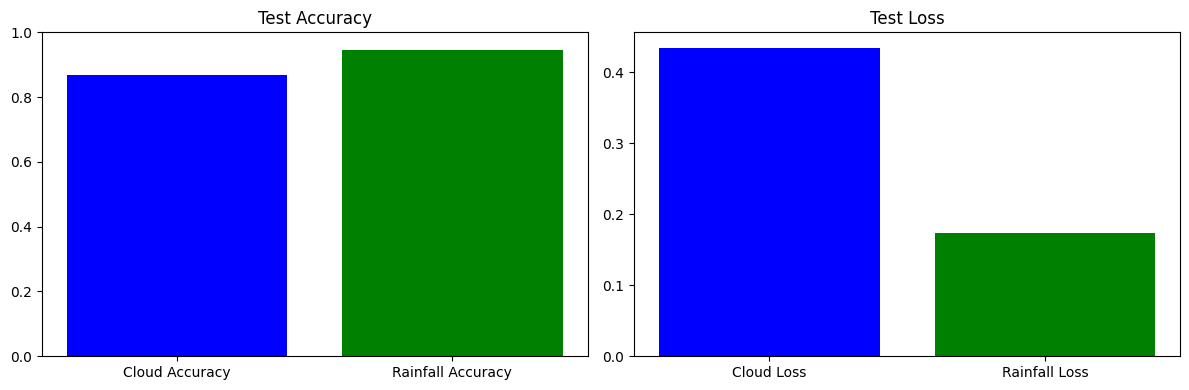

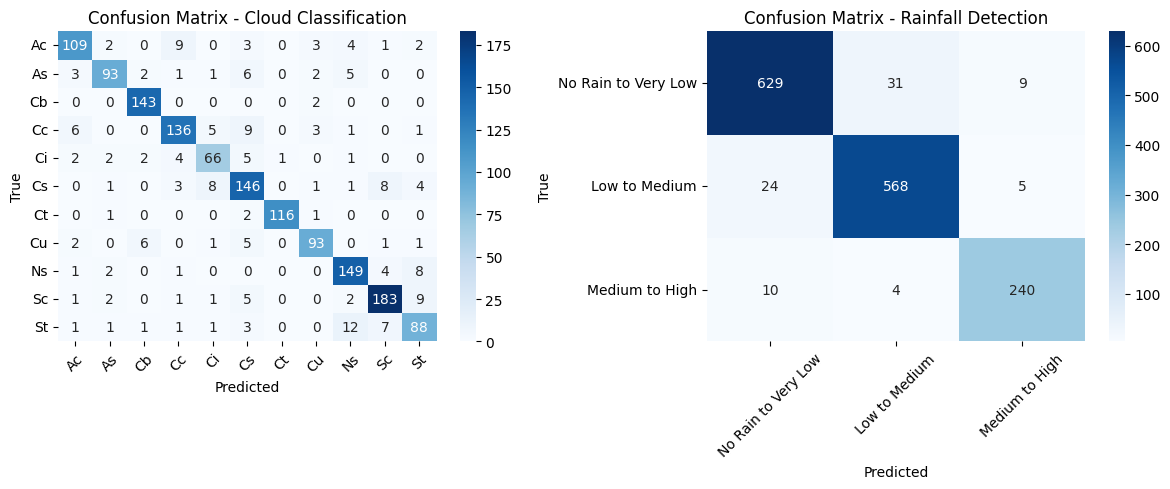

Cloud Classification Report:
              precision    recall  f1-score   support

          Ac       0.87      0.82      0.84       133
          As       0.89      0.82      0.86       113
          Cb       0.93      0.99      0.96       145
          Cc       0.87      0.84      0.86       161
          Ci       0.80      0.80      0.80        83
          Cs       0.79      0.85      0.82       172
          Ct       0.99      0.97      0.98       120
          Cu       0.89      0.85      0.87       109
          Ns       0.85      0.90      0.88       165
          Sc       0.90      0.90      0.90       204
          St       0.78      0.77      0.77       115

    accuracy                           0.87      1520
   macro avg       0.87      0.86      0.87      1520
weighted avg       0.87      0.87      0.87      1520


Rainfall Detection Report:
                     precision    recall  f1-score   support

No Rain to Very Low       0.95      0.94      0.94       669
      L

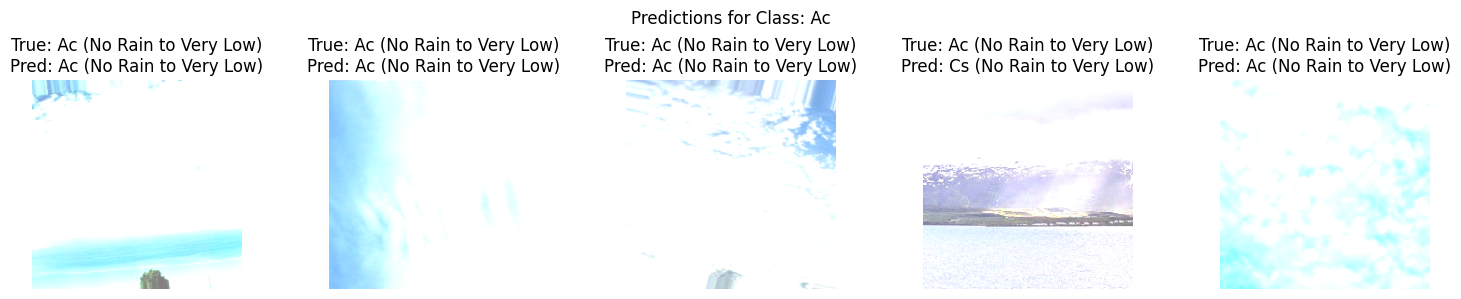

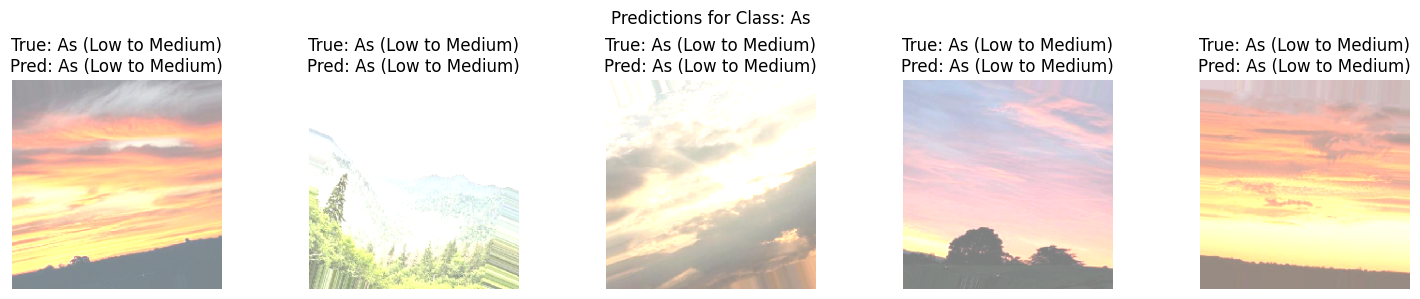

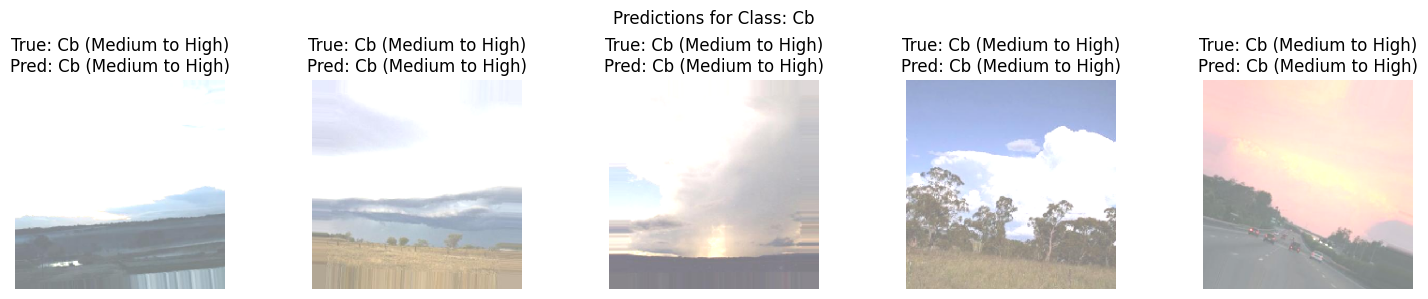

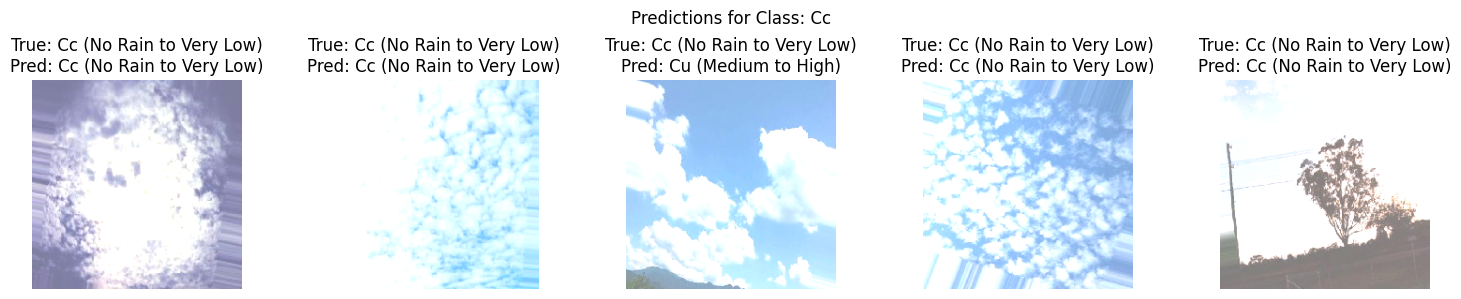

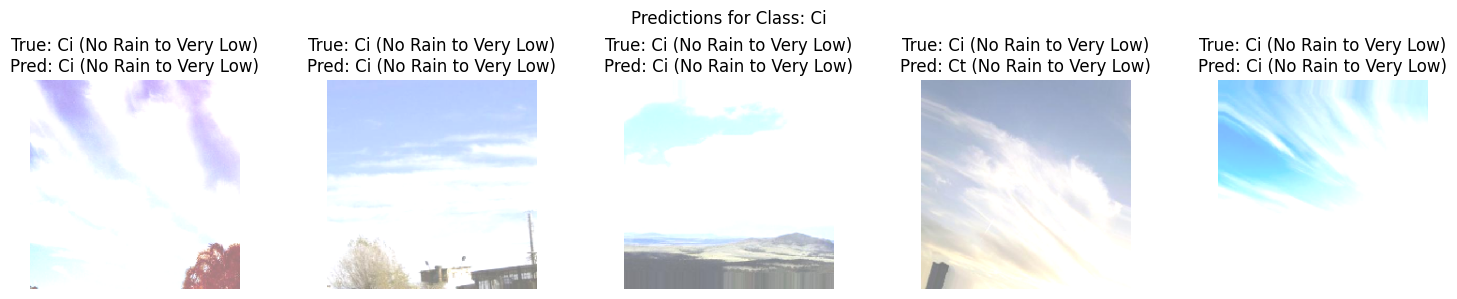

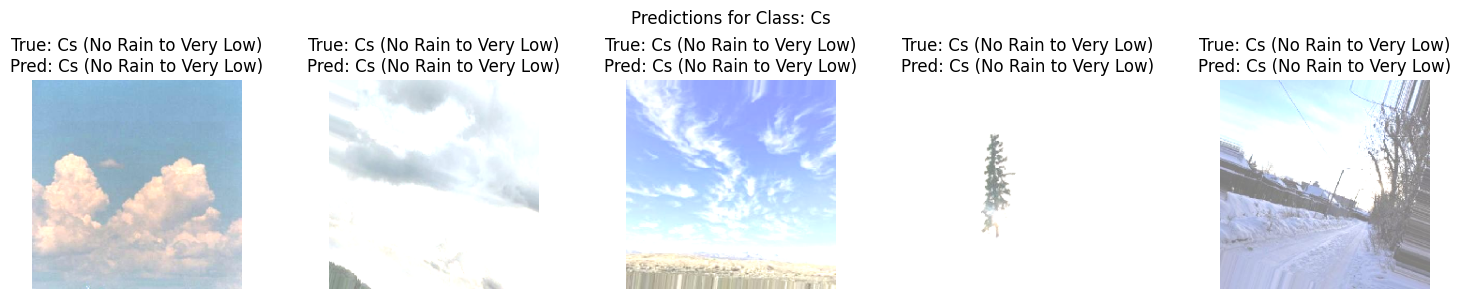

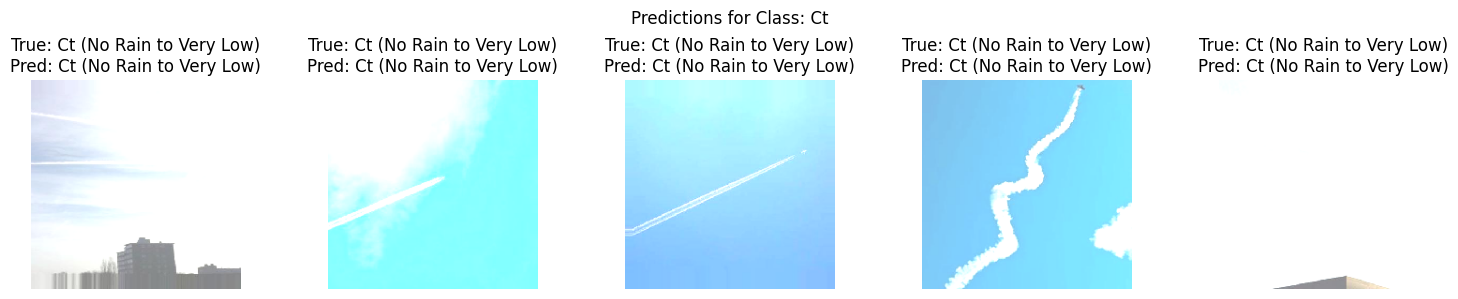

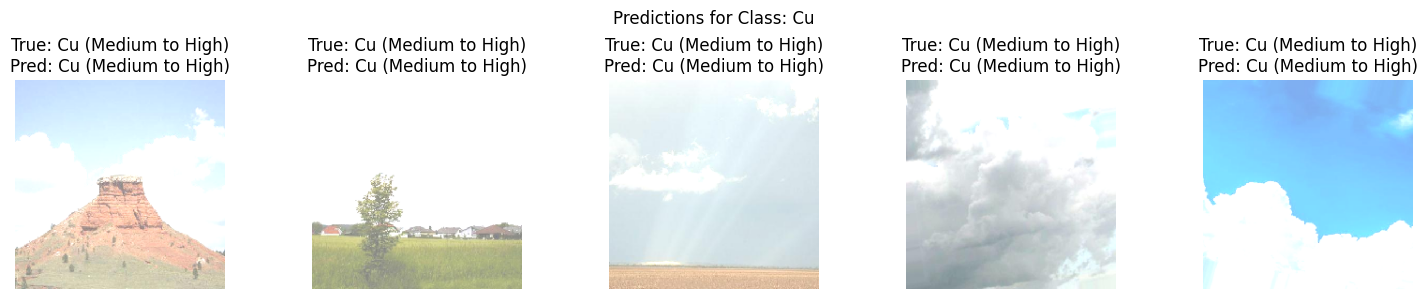

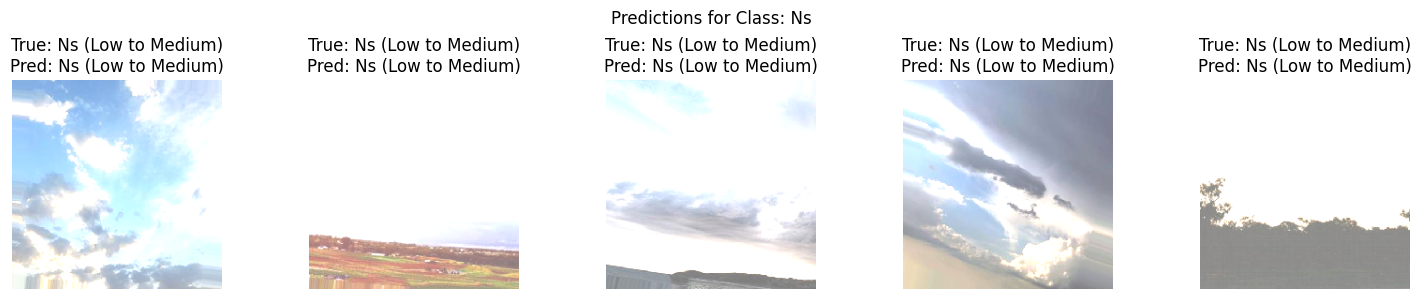

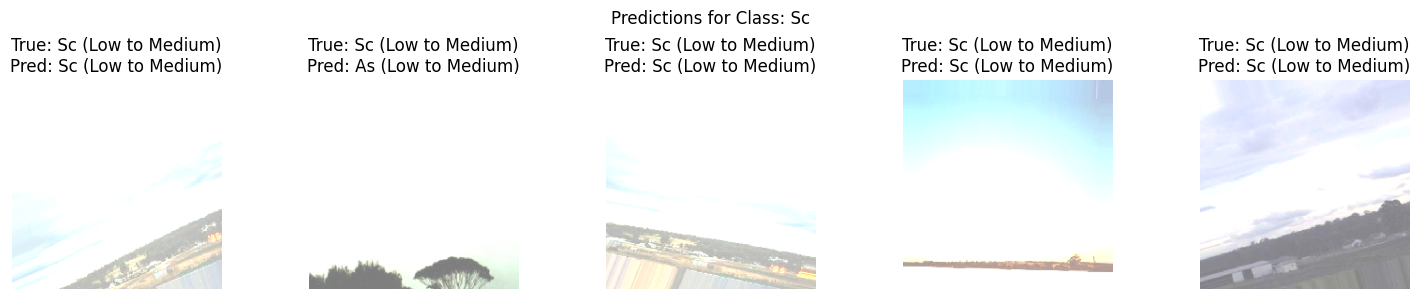

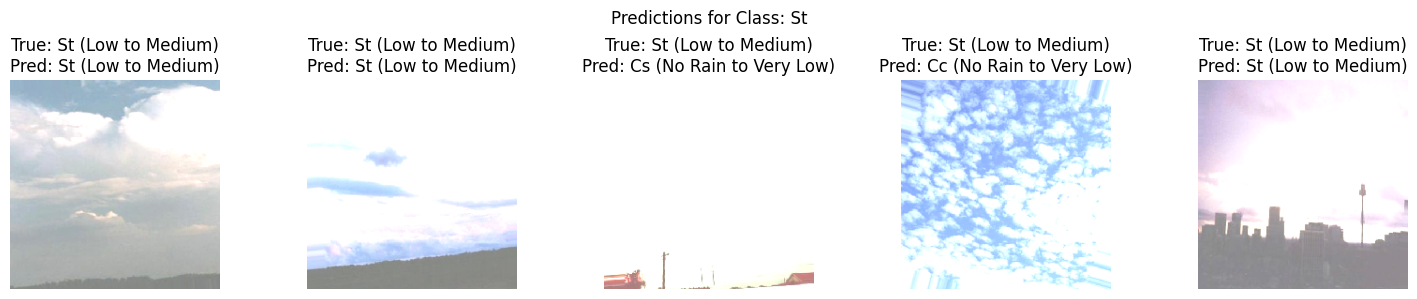

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json
import pathlib
from tensorflow.keras.models import load_model

# Load the saved model and metadata
model = load_model('/kaggle/working/cloud_rainfall_model.h5')
with open('/kaggle/working/class_names.json', 'r') as f:
    class_names = json.load(f)
with open('/kaggle/working/rainfall_mapping.json', 'r') as f:
    rainfall_mapping = json.load(f)

# Define paths
test_dir = pathlib.Path('./temp_split/test')
batch_size = 16
test_samples = 1526  # From your previous output
test_steps = test_samples // batch_size

# Define the test generator (same as your training setup)
def create_dual_output_generator(directory, batch_size=16, shuffle=False):
    datagen = ImageDataGenerator(
        rescale=1./127.5,
        preprocessing_function=lambda x: x - 1.0
    )
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=shuffle  # No shuffle for consistent evaluation
    )
    class_names_gen = sorted(generator.class_indices.keys())
    while True:
        images, cloud_labels = next(generator)
        rainfall_labels = np.array([rainfall_mapping[class_names_gen[np.argmax(label)]] 
                                   for label in cloud_labels], dtype=np.int32)
        rainfall_labels_onehot = tf.keras.utils.to_categorical(rainfall_labels, num_classes=3)
        yield images, (cloud_labels, rainfall_labels_onehot)

test_dataset = tf.data.Dataset.from_generator(
    lambda: create_dual_output_generator(test_dir, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        (
            tf.TensorSpec(shape=(None, 11), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
        )
    )
)

# Evaluate the model on test data
test_results = model.evaluate(test_dataset, steps=test_steps, return_dict=True)
print("Test Results:")
print(f"Total Loss: {test_results['loss']:.4f}")
print(f"Cloud Loss: {test_results['cloud_output_loss']:.4f}")
print(f"Rainfall Loss: {test_results['rainfall_output_loss']:.4f}")
print(f"Cloud Accuracy: {test_results['cloud_output_accuracy']:.4f}")
print(f"Rainfall Accuracy: {test_results['rainfall_output_accuracy']:.4f}")

# Collect predictions and true labels for detailed analysis
test_dataset_for_eval = test_dataset.take(test_steps)
y_true_cloud = []
y_pred_cloud = []
y_true_rain = []
y_pred_rain = []
test_images = []

for images, (cloud_labels, rainfall_labels) in test_dataset_for_eval:
    predictions = model.predict(images)
    cloud_preds = np.argmax(predictions[0], axis=1)
    rain_preds = np.argmax(predictions[1], axis=1)
    y_true_cloud.extend(np.argmax(cloud_labels, axis=1))
    y_pred_cloud.extend(cloud_preds)
    y_true_rain.extend(np.argmax(rainfall_labels, axis=1))
    y_pred_rain.extend(rain_preds)
    test_images.extend(images.numpy())

# Convert lists to numpy arrays
y_true_cloud = np.array(y_true_cloud)
y_pred_cloud = np.array(y_pred_cloud)
y_true_rain = np.array(y_true_rain)
y_pred_rain = np.array(y_pred_rain)
test_images = np.array(test_images)

# Plotting Accuracy and Loss (single point for test data)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(['Cloud Accuracy', 'Rainfall Accuracy'], 
        [test_results['cloud_output_accuracy'], test_results['rainfall_output_accuracy']], 
        color=['blue', 'green'])
plt.title('Test Accuracy')
plt.ylim(0, 1)

plt.subplot(1, 2, 2)
plt.bar(['Cloud Loss', 'Rainfall Loss'], 
        [test_results['cloud_output_loss'], test_results['rainfall_output_loss']], 
        color=['blue', 'green'])
plt.title('Test Loss')
plt.tight_layout()
plt.show()

# Confusion Matrices
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
cm_cloud = confusion_matrix(y_true_cloud, y_pred_cloud)
sns.heatmap(cm_cloud, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Cloud Classification')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.subplot(1, 2, 2)
cm_rain = confusion_matrix(y_true_rain, y_pred_rain)
rain_labels = ['No Rain to Very Low', 'Low to Medium', 'Medium to High']
sns.heatmap(cm_rain, annot=True, fmt='d', cmap='Blues', 
            xticklabels=rain_labels, yticklabels=rain_labels)
plt.title('Confusion Matrix - Rainfall Detection')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Classification Reports
print("Cloud Classification Report:")
print(classification_report(y_true_cloud, y_pred_cloud, target_names=class_names))
print("\nRainfall Detection Report:")
print(classification_report(y_true_rain, y_pred_rain, target_names=rain_labels))

# Individual Class Predictions Visualization
def plot_class_predictions(class_idx, class_name, num_examples=5):
    # Find indices where true label matches the class
    class_indices = np.where(y_true_cloud == class_idx)[0]
    if len(class_indices) == 0:
        print(f"No true instances of {class_name} found in test data.")
        return
    
    # Randomly select examples
    selected_indices = np.random.choice(class_indices, min(num_examples, len(class_indices)), replace=False)
    
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(selected_indices):
        img = test_images[idx] * 127.5 + 127.5  # Undo preprocessing for visualization
        img = np.clip(img, 0, 255).astype(np.uint8)
        
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(img)
        true_cloud = class_names[y_true_cloud[idx]]
        pred_cloud = class_names[y_pred_cloud[idx]]
        true_rain = rain_labels[y_true_rain[idx]]
        pred_rain = rain_labels[y_pred_rain[idx]]
        plt.title(f"True: {true_cloud} ({true_rain})\nPred: {pred_cloud} ({pred_rain})")
        plt.axis('off')
    plt.suptitle(f"Predictions for Class: {class_name}")
    plt.tight_layout()
    plt.show()

# Plot predictions for each cloud class
for idx, class_name in enumerate(class_names):
    plot_class_predictions(idx, class_name)

# Optionally, save results
with open('/kaggle/working/test_results.json', 'w') as f:
    json.dump(test_results, f)

Found 1526 images belonging to 11 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━

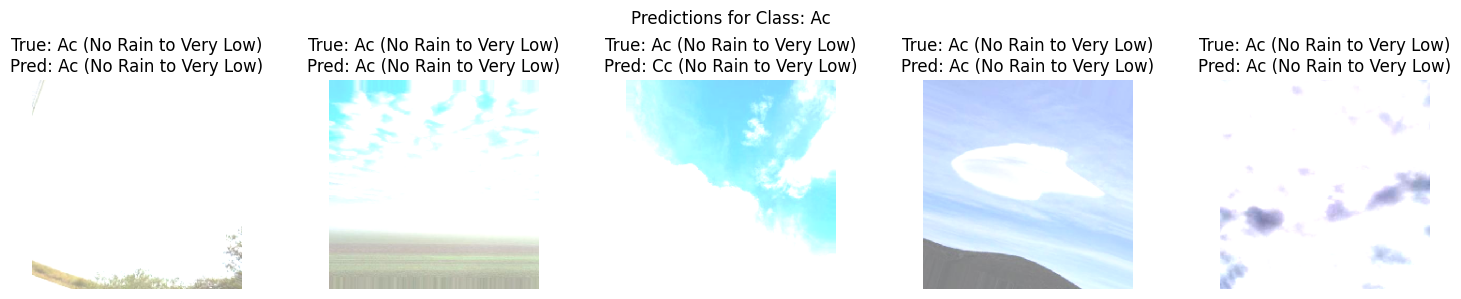

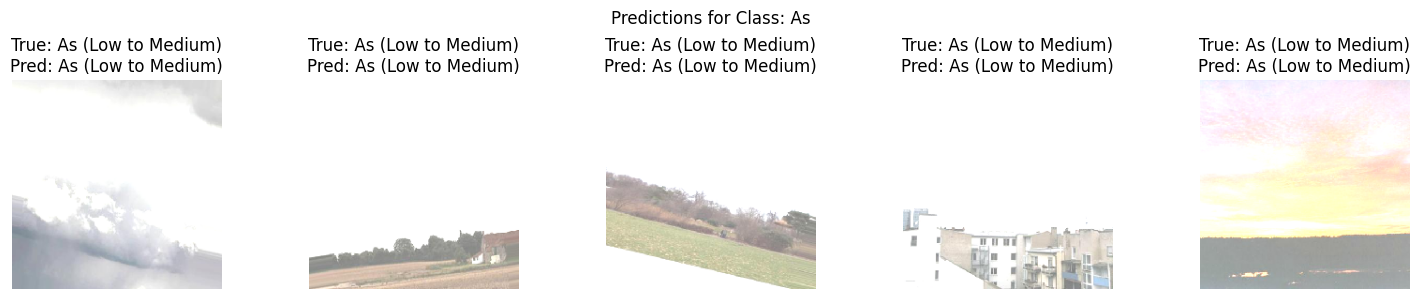

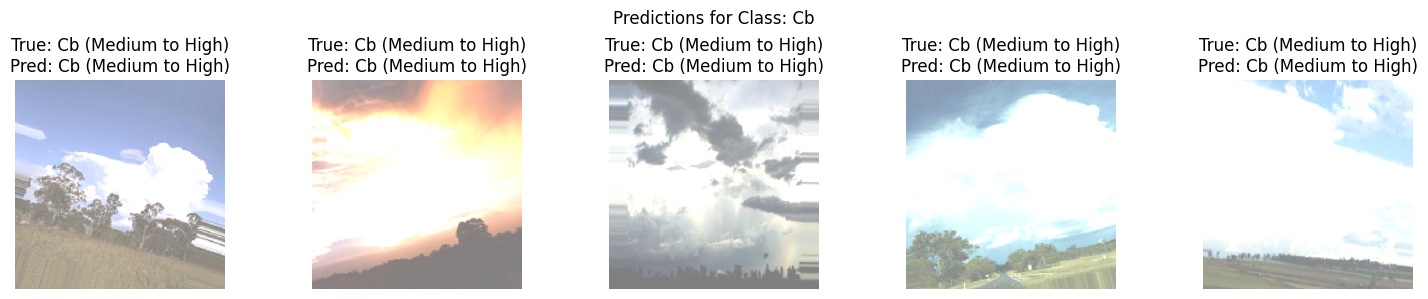

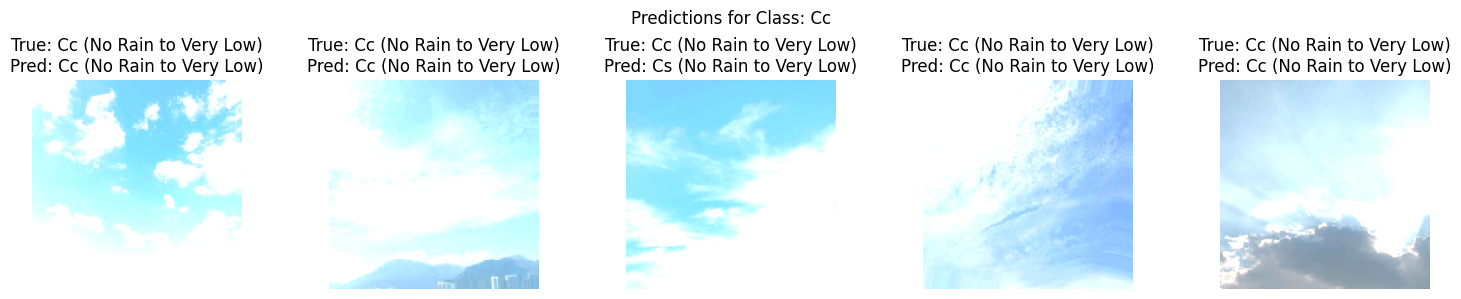

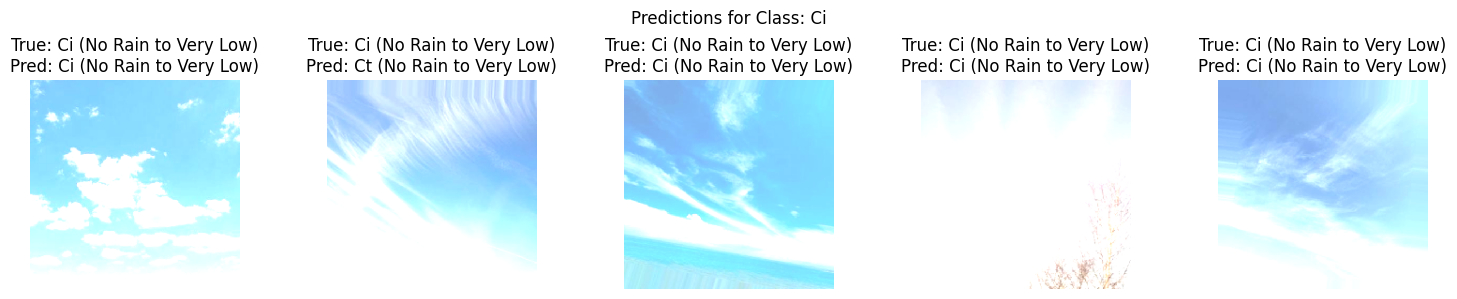

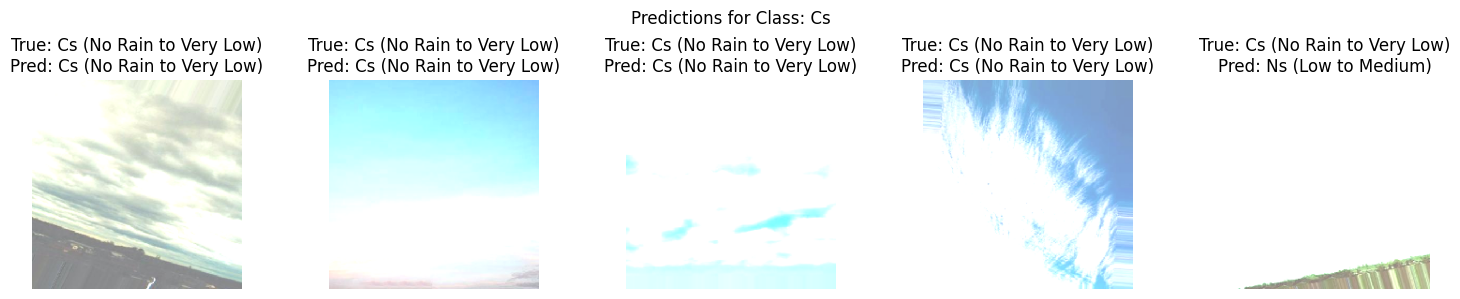

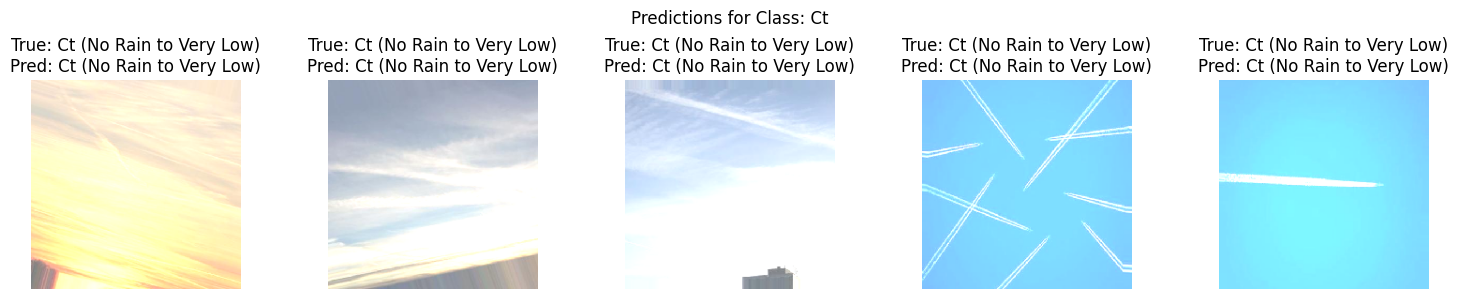

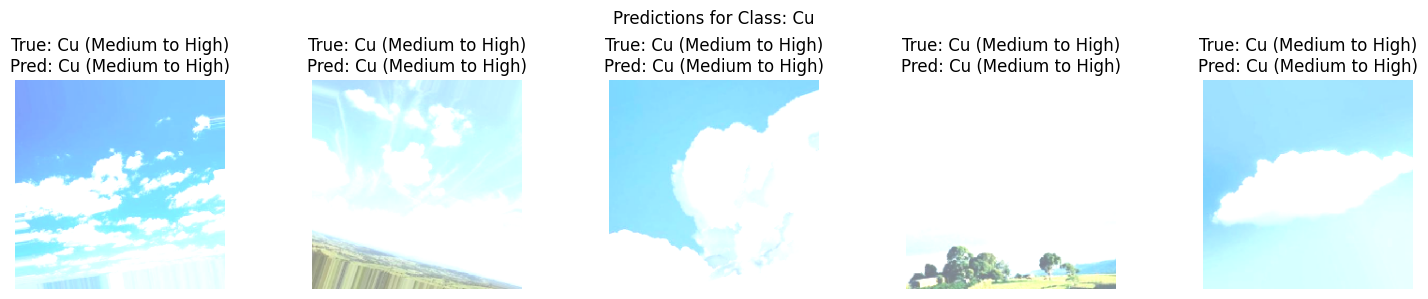

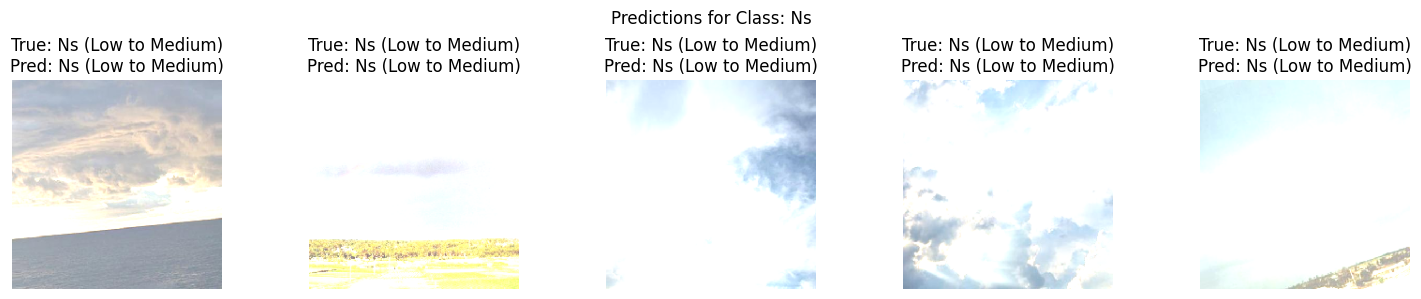

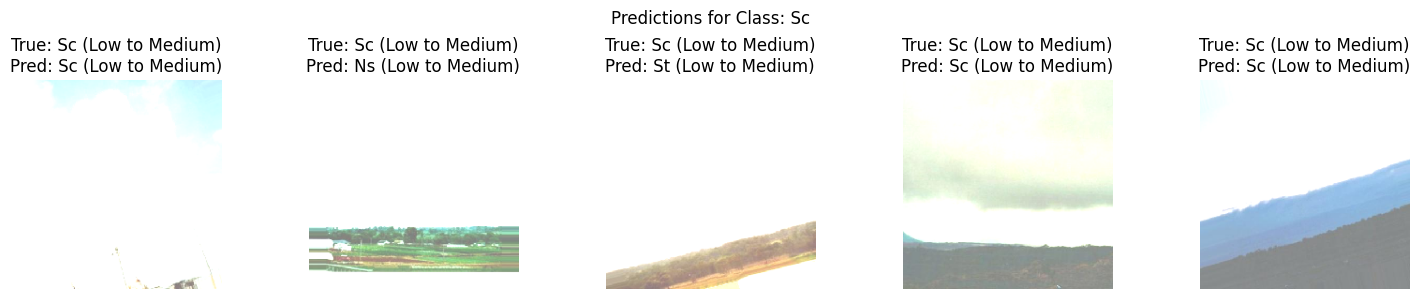

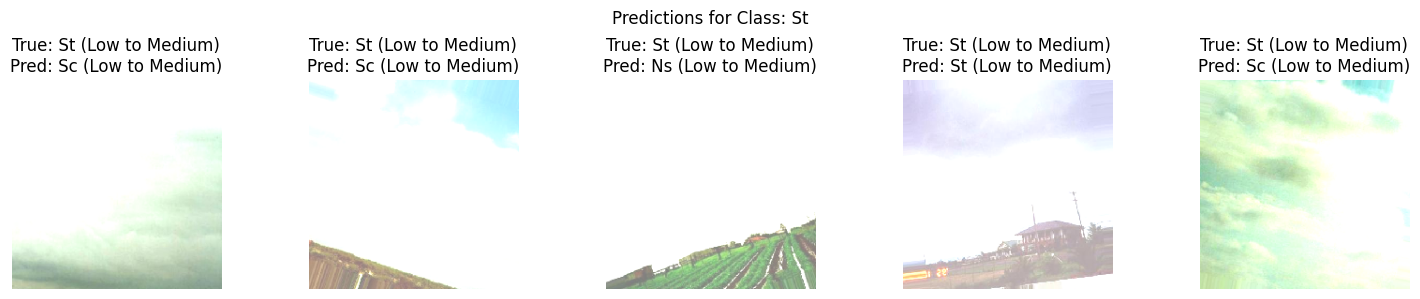

In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import json
from tensorflow.keras.models import load_model
import pathlib

# Load the saved model and metadata
model = load_model('/kaggle/working/cloud_rainfall_model.h5')
with open('/kaggle/working/class_names.json', 'r') as f:
    class_names = json.load(f)
with open('/kaggle/working/rainfall_mapping.json', 'r') as f:
    rainfall_mapping = json.load(f)

# Define paths and parameters
test_dir = pathlib.Path('./temp_split/test')
batch_size = 16
test_samples = 1526
test_steps = test_samples // batch_size

# Define the test generator
def create_dual_output_generator(directory, batch_size=16, shuffle=False):
    datagen = ImageDataGenerator(
        rescale=1./127.5,
        preprocessing_function=lambda x: x - 1.0
    )
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=shuffle
    )
    class_names_gen = sorted(generator.class_indices.keys())
    while True:
        images, cloud_labels = next(generator)
        rainfall_labels = np.array([rainfall_mapping[class_names_gen[np.argmax(label)]] 
                                   for label in cloud_labels], dtype=np.int32)
        rainfall_labels_onehot = tf.keras.utils.to_categorical(rainfall_labels, num_classes=3)
        yield images, (cloud_labels, rainfall_labels_onehot)

test_dataset = tf.data.Dataset.from_generator(
    lambda: create_dual_output_generator(test_dir, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        (
            tf.TensorSpec(shape=(None, 11), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
        )
    )
)

# Collect predictions, true labels, and images
test_dataset_for_eval = test_dataset.take(test_steps)
y_true_cloud = []
y_pred_cloud = []
y_true_rain = []
y_pred_rain = []
test_images = []

for images, (cloud_labels, rainfall_labels) in test_dataset_for_eval:
    predictions = model.predict(images)
    cloud_preds = np.argmax(predictions[0], axis=1)
    rain_preds = np.argmax(predictions[1], axis=1)
    y_true_cloud.extend(np.argmax(cloud_labels, axis=1))
    y_pred_cloud.extend(cloud_preds)
    y_true_rain.extend(np.argmax(rainfall_labels, axis=1))
    y_pred_rain.extend(rain_preds)
    test_images.extend(images.numpy())

y_true_cloud = np.array(y_true_cloud)
y_pred_cloud = np.array(y_pred_cloud)
y_true_rain = np.array(y_true_rain)
y_pred_rain = np.array(y_pred_rain)
test_images = np.array(test_images)

# Function to plot predictions for a specific class
def plot_class_predictions(class_idx, class_name, num_examples=5):
    class_indices = np.where(y_true_cloud == class_idx)[0]
    if len(class_indices) == 0:
        print(f"No true instances of {class_name} found in test data.")
        return
    
    selected_indices = np.random.choice(class_indices, min(num_examples, len(class_indices)), replace=False)
    
    plt.figure(figsize=(15, 3))
    rain_labels = ['No Rain to Very Low', 'Low to Medium', 'Medium to High']
    for i, idx in enumerate(selected_indices):
        img = test_images[idx] * 127.5 + 127.5  # Undo preprocessing
        img = np.clip(img, 0, 255).astype(np.uint8)
        
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(img)
        true_cloud = class_names[y_true_cloud[idx]]
        pred_cloud = class_names[y_pred_cloud[idx]]
        true_rain = rain_labels[y_true_rain[idx]]
        pred_rain = rain_labels[y_pred_rain[idx]]
        plt.title(f"True: {true_cloud} ({true_rain})\nPred: {pred_cloud} ({pred_rain})")
        plt.axis('off')
    plt.suptitle(f"Predictions for Class: {class_name}")
    plt.tight_layout()
    plt.show()

# Plot predictions for each cloud class
for idx, class_name in enumerate(class_names):
    plot_class_predictions(idx, class_name)

Found 10680 images belonging to 11 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━

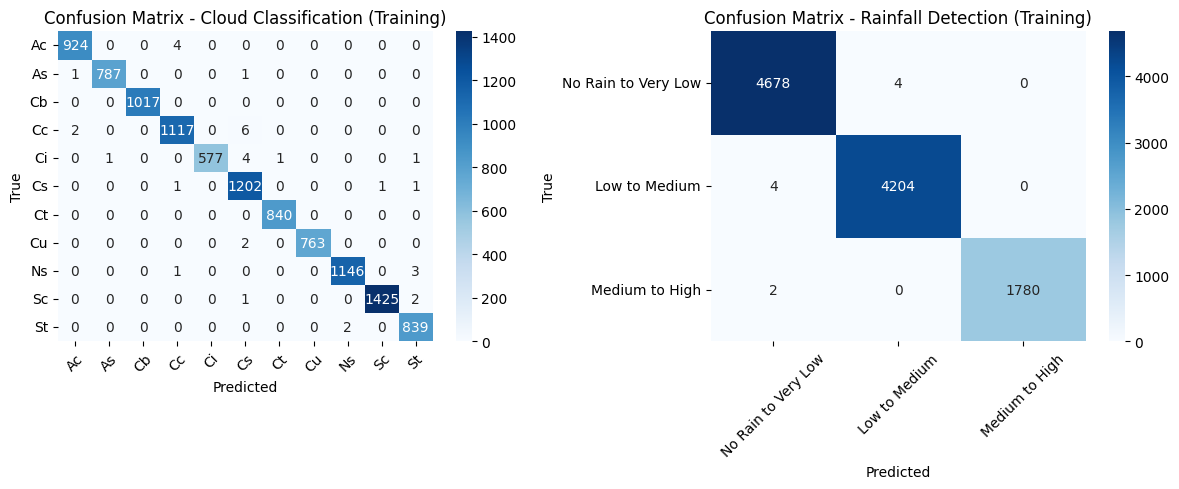

In [29]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import json
from tensorflow.keras.models import load_model
import pathlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the saved model and metadata
model = load_model('/kaggle/working/cloud_rainfall_model.h5')
with open('/kaggle/working/class_names.json', 'r') as f:
    class_names = json.load(f)
with open('/kaggle/working/rainfall_mapping.json', 'r') as f:
    rainfall_mapping = json.load(f)

# Define paths and parameters
train_dir = pathlib.Path('./temp_split/train')
batch_size = 16
train_samples = 10678  # From your previous output
train_steps = train_samples // batch_size  # Approximately 667 steps

# Define the training generator
def create_dual_output_generator(directory, batch_size=16, shuffle=False):
    datagen = ImageDataGenerator(
        rescale=1./127.5,
        preprocessing_function=lambda x: x - 1.0
    )
    generator = datagen.flow_from_directory(
        directory,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=shuffle  # Set to False for consistent evaluation
    )
    class_names_gen = sorted(generator.class_indices.keys())
    while True:
        images, cloud_labels = next(generator)
        rainfall_labels = np.array([rainfall_mapping[class_names_gen[np.argmax(label)]] 
                                   for label in cloud_labels], dtype=np.int32)
        rainfall_labels_onehot = tf.keras.utils.to_categorical(rainfall_labels, num_classes=3)
        yield images, (cloud_labels, rainfall_labels_onehot)

train_dataset = tf.data.Dataset.from_generator(
    lambda: create_dual_output_generator(train_dir, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        (
            tf.TensorSpec(shape=(None, 11), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
        )
    )
)

# Collect predictions and true labels for training data
train_dataset_for_eval = train_dataset.take(train_steps)
y_true_cloud = []
y_pred_cloud = []
y_true_rain = []
y_pred_rain = []

for images, (cloud_labels, rainfall_labels) in train_dataset_for_eval:
    predictions = model.predict(images)
    cloud_preds = np.argmax(predictions[0], axis=1)
    rain_preds = np.argmax(predictions[1], axis=1)
    y_true_cloud.extend(np.argmax(cloud_labels, axis=1))
    y_pred_cloud.extend(cloud_preds)
    y_true_rain.extend(np.argmax(rainfall_labels, axis=1))
    y_pred_rain.extend(rain_preds)

y_true_cloud = np.array(y_true_cloud)
y_pred_cloud = np.array(y_pred_cloud)
y_true_rain = np.array(y_true_rain)
y_pred_rain = np.array(y_pred_rain)

# Plot Confusion Matrices
plt.figure(figsize=(12, 5))

# Cloud Confusion Matrix (Training)
plt.subplot(1, 2, 1)
cm_cloud = confusion_matrix(y_true_cloud, y_pred_cloud)
sns.heatmap(cm_cloud, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Cloud Classification (Training)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Rainfall Confusion Matrix (Training)
plt.subplot(1, 2, 2)
cm_rain = confusion_matrix(y_true_rain, y_pred_rain)
rain_labels = ['No Rain to Very Low', 'Low to Medium', 'Medium to High']
sns.heatmap(cm_rain, annot=True, fmt='d', cmap='Blues', 
            xticklabels=rain_labels, yticklabels=rain_labels)
plt.title('Confusion Matrix - Rainfall Detection (Training)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

# Optional: Save confusion matrices as numpy arrays
np.save('/kaggle/working/cm_cloud_train.npy', cm_cloud)
np.save('/kaggle/working/cm_rain_train.npy', cm_rain)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ xception (Functional)     │ (None, 7, 7, 2048)     │     20,861,480 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ xception[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 2048)           │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cloud_output (Dense)      │ (None, 11)             │         22,539 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rainfall_output (Dense)   │ (None, 3)              │          6,147 │ dropout[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 20,890,168 (79.69 MB)

 Trainable params: 18,116,358 (69.11 MB)

 Non-trainable params: 2,773,808 (10.58 MB)

 Optimizer params: 2 (12.00 B)


Inspecting Model Weights:
Layer: xception
  Weight 0 shape: (3, 3, 3, 32)
  Weight 0 mean: -0.0016, std: 0.4206
  Weight 1 shape: (32,)
  Weight 1 mean: 1.0000, std: 0.0000
  Weight 2 shape: (32,)
  Weight 2 mean: 0.1586, std: 1.6263
  Weight 3 shape: (32,)
  Weight 3 mean: -0.0633, std: 0.2832
  Weight 4 shape: (32,)
  Weight 4 mean: 1.3697, std: 1.0194
  Weight 5 shape: (3, 3, 32, 64)
  Weight 5 mean: 0.0023, std: 0.1838
  Weight 6 shape: (64,)
  Weight 6 mean: 1.0000, std: 0.0000
  Weight 7 shape: (64,)
  Weight 7 mean: 0.2966, std: 1.4492
  Weight 8 shape: (64,)
  Weight 8 mean: -0.3772, std: 3.1987
  Weight 9 shape: (64,)
  Weight 9 mean: 8.8040, std: 13.6506
  Weight 10 shape: (3, 3, 64, 1)
  Weight 10 mean: 0.0098, std: 0.4070
  Weight 11 shape: (1, 1, 64, 128)
  Weight 11 mean: -0.0029, std: 0.1617
  Weight 12 shape: (128,)
  Weight 12 mean: 1.0000, std: 0.0000
  Weight 13 shape: (128,)
  Weight 13 mean: 0.1348, std: 0.5299
  Weight 14 shape: (128,)
  Weight 14 mean: -0.5228, 

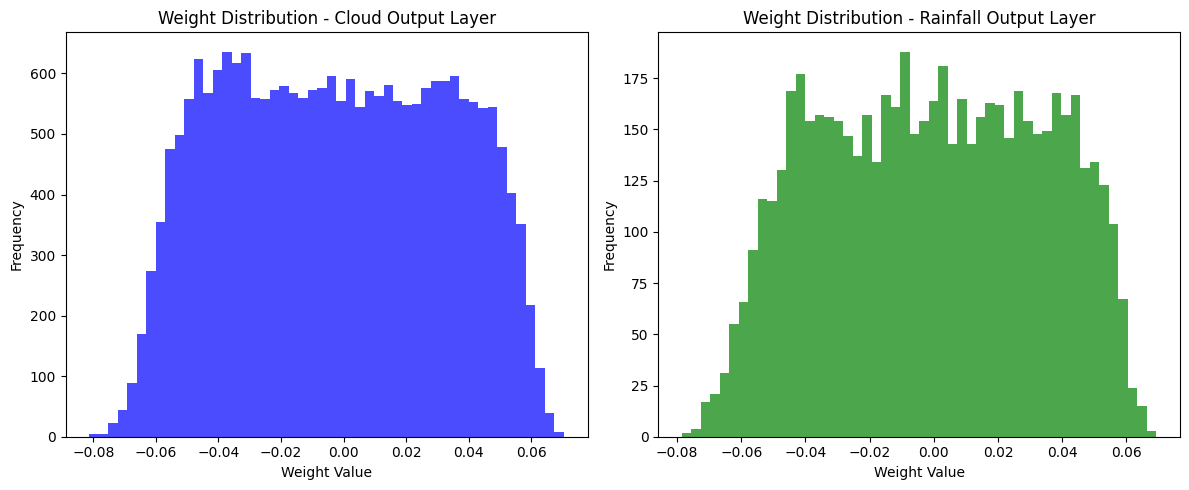

In [13]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load the saved model
model = load_model('/kaggle/working/cloud_rainfall_model.h5')

# Print model summary to see layers
model.summary()

# Access and inspect weights
print("\nInspecting Model Weights:")
for layer in model.layers:
    weights = layer.get_weights()
    if weights:  # Only layers with weights (e.g., Dense, Conv2D)
        print(f"Layer: {layer.name}")
        for i, w in enumerate(weights):
            print(f"  Weight {i} shape: {w.shape}")
            print(f"  Weight {i} mean: {np.mean(w):.4f}, std: {np.std(w):.4f}")

# Visualize weight distribution (example for the final Dense layers)
cloud_dense_weights = model.get_layer('cloud_output').get_weights()[0]  # Weights of cloud_output layer
rainfall_dense_weights = model.get_layer('rainfall_output').get_weights()[0]  # Weights of rainfall_output layer

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(cloud_dense_weights.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Weight Distribution - Cloud Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(rainfall_dense_weights.flatten(), bins=50, color='green', alpha=0.7)
plt.title('Weight Distribution - Rainfall Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

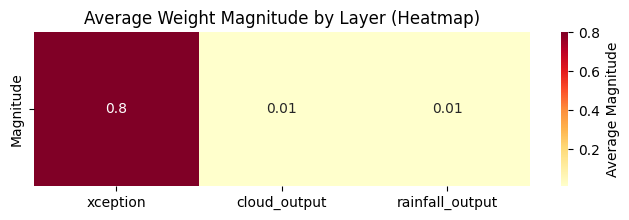

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Data
layers = ['xception', 'cloud_output', 'rainfall_output']
avg_magnitudes = [0.8, 0.01, 0.01]

# Reshape for heatmap (1 row)
data = np.array(avg_magnitudes).reshape(1, -1)

# Plot
plt.figure(figsize=(8, 2))
sns.heatmap(data, annot=True, cmap='YlOrRd', xticklabels=layers, yticklabels=['Magnitude'], cbar_kws={'label': 'Average Magnitude'})
plt.title('Average Weight Magnitude by Layer (Heatmap)')
plt.show()

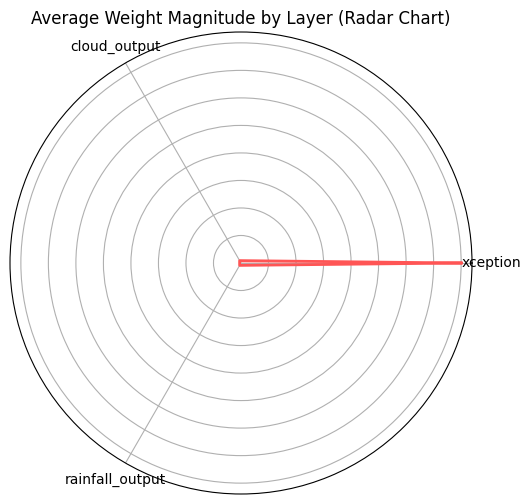

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi

# Data
layers = ['xception', 'cloud_output', 'rainfall_output']
avg_magnitudes = [0.8, 0.01, 0.01]

# Repeat the first value to close the circle
values = avg_magnitudes + [avg_magnitudes[0]]
angles = [n / float(len(layers)) * 2 * pi for n in range(len(layers))]
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, values, color='#FF9999', alpha=0.5)
ax.plot(angles, values, color='#FF5555', linewidth=2)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(layers)
plt.title('Average Weight Magnitude by Layer (Radar Chart)')
plt.show()